# Autoregression

[Link to the Video](https://www.youtube.com/watch?v=xDVOwL1fAZI&list=PLKmQjl_R9bYd32uHImJxQSFZU5LPuXfQe&index=15)

## Intro

Forecasting is a wide domain with many models available to simulate your time series. In my previous posts, we covered some basic forecasting models and explored the popular family of exponential smoothing models.

In this post, we will start our journey into another family of forecasting models beginning with autoregression. We will go over the necessary theory and background needed to forecast with this model and then dive into a tutorial with Python.

## What is Autoregression?

Autoregression is when you forecast a time series using some linear weighted combination of the previous values (lags) of that time series. As we are regressing a target value against itself, it is called auto-regression. Mathematically, we can write autoregression as:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t
$$

Where y is the time series we are forecasting at various time steps, ϕ are the fitted coefficients of the lags for the time series, ε is the error term (typically normally distributed) and p is the number of lagged components included in the model, this is also known as the order.

A few well known models pop out of this autoregression equation:

- If we have no coefficients or they are all zero, then this is just white noise
- If we only have ϕ_1 = 1 and the other coefficients are zero, then this is a random walk.

### Requirements

To build an autoregressive model, it is recommended to have a stationary time series. Stationarity means the time series doesn’t exhibit any long term trend or obvious seasonality. The reason we need stationarity it to ensure the statistical properties of the time series is consistent through time, rendering it easier to model (explained in more detail later).

Stationarity can be achieved by stabilising the trend through differencing and stabilising the variance through a Logarithm or Box-Cox transform.

### Estimation

The need for stationarity becomes clearer when we are training the model. Stationary data has constant statistical properties such as mean and variance. Therefore, all the data points belong to the same statistical probability distribution that we can base our model on. Furthermore, the forecasts are treated as random variables and will belong to the same distribution as the training data (lags). It basically guarantees the data in the future will be somewhat like the past.

As the stationary data belongs to some distribution (typically the normal distribution), we often estimate the coefficients and parameters of the autoregressive model using Maximum Likelihood Estimation (MLE). MLE deduces the optimal values of the parameters and coefficients that produce the highest probability of obtaining our time series data. The MLE for normally distributed data, is the same result as carrying ordinary least squares. Therefore, least squares is also frequently used.

### Order Selection

Before fitting and estimating the model, we need to know how many lags (the order), p, to include. One way of doing this is through plotting the partial autocorrelation function (PACF) of the time series. This measures how much certain lags directly correlate with each other. Hence, we can deduce which lags are most statistically significant and remove the ones that are not when constructing our model. We will go over how to carry out this process in the Python tutorial later in the article.

However, another more thorough technique is to simply iterate over all the possible combinations of lag components and choose the model with the best score on the AIC. This is analogous to regular hyperparameter tuning and definitely the more robust method, but is subject to computational constraints of course.

In [1]:
# Import packages
import plotly.express as px
import pandas as pd

In [2]:
# Read in the data
data = pd.read_csv('../data/airline.csv')
data['Month'] = pd.to_datetime(data['Month'])

In [3]:
def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()

In [4]:
# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

The time series has a clear trend and obvious yearly seasonality that is increasing through time. Therefore, we need to make it stationary by carrying out differencing and applying the Box-Cox transform:

In [5]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_stationary"] = data["Passengers_boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data, y='Passenger_stationary')

### Modeling

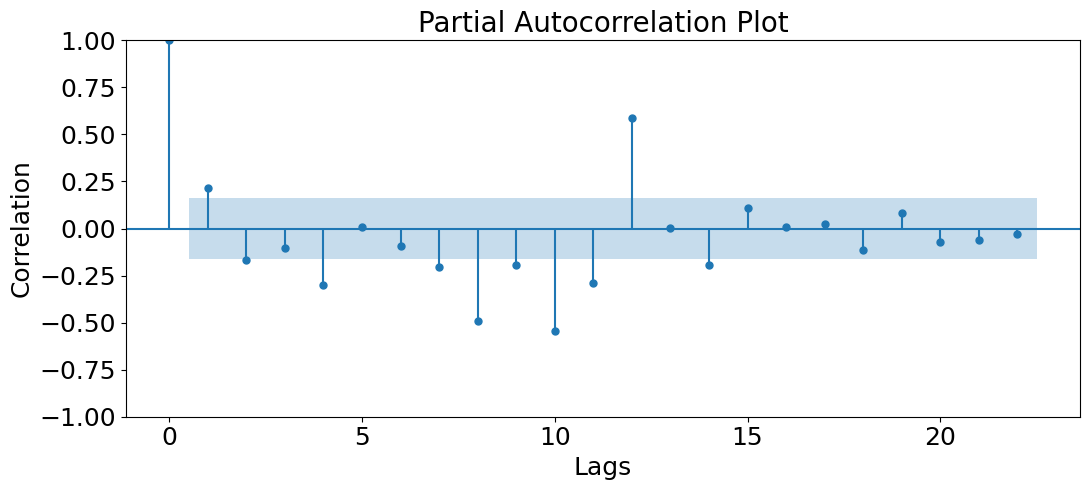

In [6]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['Passenger_stationary'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

The lags outside the blue shaded region are classed as significantly significant and should be included as the features for our autoregressive model. From the above plot, it seems lags 1, 2, 4, 7, 8, 9, 10, 11, 12 and 13 are significant. Notice how lag 12 has the largest peak. This is because our time series is indexed by month and has a yearly seasonality, hence lag 12 is an exact year difference.

However, for building our model we will use the recommended approach of simply iterating over all the possible combinations of lags and choose the best model from that analysis. As our dataset is quite small, this is easily computationally feasible.

Here we use the statsmodels ar_select_order to determine the optimal number of lags to include in the autoregressive model. In this case, we have set our model to try combinations up to lag 15. The model is then fit with the results from the ar_select_order using the AutoReg class from statsmodels.

In [8]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build AR model
selector = ar_select_order(train['Passenger_stationary'], 15)
model = AutoReg(train['Passenger_stationary'], lags=selector.ar_lags).fit()

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



### Results

The forecasts produced from this fitted model is for the differenced and Box-Cox transformed time series that we produced earlier. Therefore, we have to un-difference and apply the inverse Box-Cox transform to the predictions to acquire the actual airline passenger forecasted volumes:

In [10]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Our autoregressive model forecasts have adequately captured the trend and seasonality in the time series. However, the seasonality was captured as a result of the model having an order (lags) of 13. This means it includes all the lags in the past year (one for each month) to forecast, which leads it easily pick-up the seasonality due to how regular it is.